In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import roc_auc_score


# Get Data

In [32]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst", "Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)

No need to standardise as not sensitive to magnitude. So we can now split into test and train sets. Remove Area and Perimeter as they are very correlated, due to being function of radius.

In [33]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.25, stratify=label)

# Create & Train Model

In [34]:
rfc = RandomForestClassifier(random_state=0, n_estimators=10)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print('Confusion matrix\n\n', cm)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
# We want a higher Recall, as it accounts for false negatives - which we care about

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        90
           1       1.00      0.87      0.93        53

    accuracy                           0.95       143
   macro avg       0.96      0.93      0.95       143
weighted avg       0.95      0.95      0.95       143

Confusion matrix

 [[90  0]
 [ 7 46]]
Accuracy: 0.951048951048951
Recall: 0.8679245283018868
Precision: 1.0


In [35]:
# We use this instead to determine the most important features
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)
feature_scores = feature_scores.index.tolist()
important_features = feature_scores[:-11]
print(important_features)
feature = df[important_features]
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.25, stratify=label)


RadiusWorst              0.257880
Concavity                0.248624
ConcavePointsWorst       0.093719
Compactness              0.080584
Radius                   0.038339
CompactnessWorst         0.037843
RadiusSE                 0.033800
ConcavePoints            0.030395
ConcavityWorst           0.022633
FractalDimensionSE       0.020524
CompactnessSE            0.015911
TextureWorst             0.014407
FractalDimension         0.014290
Symmetry                 0.012087
SymmetryWorst            0.010985
SmoothnessSE             0.010436
Texture                  0.010068
SmoothnessWorst          0.009447
FractalDimensionWorst    0.009442
SymmetrySE               0.009219
ConcavePointsSE          0.005547
Smoothness               0.005139
ConcavitySE              0.004374
TextureSE                0.004308
dtype: float64
['RadiusWorst', 'Concavity', 'ConcavePointsWorst', 'Compactness', 'Radius', 'CompactnessWorst', 'RadiusSE', 'ConcavePoints', 'ConcavityWorst', 'FractalDimensionSE', 'Com

In [36]:
# trying it again with different columns
rfc = RandomForestClassifier(random_state=0, n_estimators=100)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(confusion_matrix(y_test, y_pred))



Accuracy: 0.9790209790209791
Recall: 0.9433962264150944
Precision: 1.0
[[90  0]
 [ 3 50]]


Model loses accuracy when we remove most irrelevent features, sign of overfitting

# Hyperparameter Tuning

In [37]:
n_estimators = [int(x) for x in range(1,100,1)]
max_depth = [int(x) for x in np.linspace(20, 150, num = 5)]
max_depth.append(None)
max_features = ['sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [38]:
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)
rfc = rf_random.best_estimator_
y_pred = rfc.predict(x_test)
print(rf_random.best_estimator_)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
RandomForestClassifier(bootstrap=False, max_depth=52, min_samples_split=5,
                       n_estimators=61, random_state=0)
Accuracy: 0.986013986013986
Recall: 0.9622641509433962
Precision: 1.0


# Test for over/ underfitting



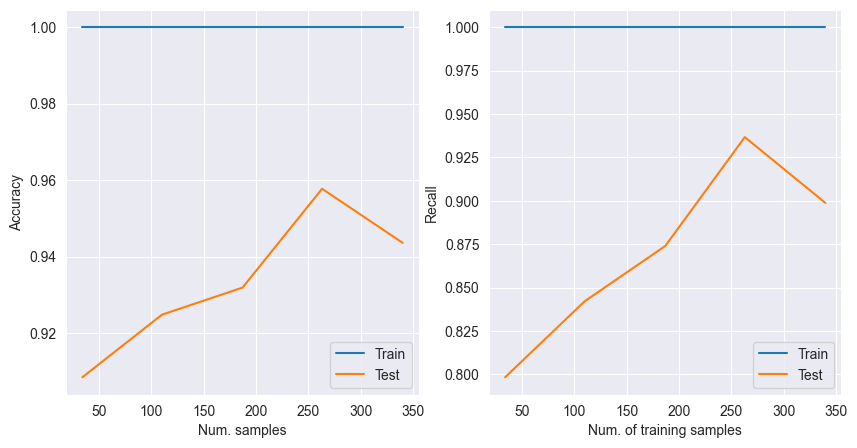

In [39]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=rfc, X=x_train, y=y_train, scoring='accuracy', cv=5)

train_sizes_abs_error, train_error, test_error = learning_curve(estimator=rfc, X=x_train, y=y_train, scoring='recall', cv=5)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Array of tuples (train_size, train_score)
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []

for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Test'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

100% accuracy and not changing with the number of samples is clearly overfitting, so we will manually remove the least significant variables we calculated to simplify our model - so that we can make up for our lack of instances. When writing up this report, we can do these graphs twice - once with many variable and second with few

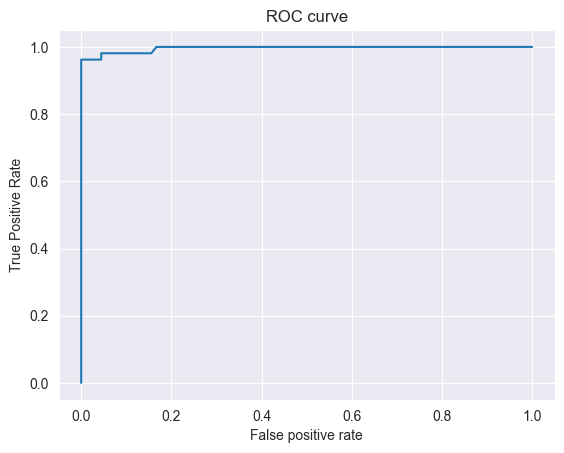

In [40]:
# After hyperparameter tuning* and feature selection*
auc = roc_auc_score(y_test, y_pred)



y_pred_prob = rfc.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()
